In [ ]:
import pm4py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Create output directory
output_dir = Path("../../Results/Advanced_Analysis/concept_drift")
output_dir.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully")


In [ ]:

log_path = "../../Dataset/BPI Challenge 2017.xes"
log = pm4py.read_xes(log_path)
df = pm4py.convert_to_dataframe(log)



Loaded 1,202,267 events
Date range: 2016-01-01 09:51:15.304000+00:00 to 2017-02-01 14:11:03.499000+00:00
Number of cases: 31,509


In [ ]:
# Create time windows (monthly)
df['year_month'] = df['time:timestamp'].dt.to_period('M')
df['year_month_str'] = df['year_month'].astype(str)

# Get case-level data
case_data = df.groupby('case:concept:name').agg({
    'time:timestamp': ['min', 'max'],
    'concept:name': lambda x: ' -> '.join(x.astype(str)),
    'case:LoanGoal': 'first',
    'case:ApplicationType': 'first',
    'case:RequestedAmount': 'first' #Stupid but works for now
}).reset_index()
case_data.columns = ['case_id', 'start_time', 'end_time', 'variant', 'loan_goal', 'app_type', 'requested_amount']
case_data['duration_days'] = (case_data['end_time'] - case_data['start_time']).dt.total_seconds() / (24 * 3600)
case_data['year_month'] = case_data['start_time'].dt.to_period('M')
case_data['year_month_str'] = case_data['year_month'].astype(str)

# Determine case outcomes based on whether endpoint activities appear anywhere in the trace
# Get all activities for each case
case_activities = df.groupby('case:concept:name')['concept:name'].apply(list).reset_index()
case_activities.columns = ['case_id', 'activities']
case_data = case_data.merge(case_activities, on='case_id', how='left')

# Classify outcomes based on whether endpoint activities appear in the trace
def classify_outcome(activities):
    # Check if activities is None or empty
    if activities is None:
        return 'Unknown'
    try:
        if len(activities) == 0:
            return 'Unknown'
    except (TypeError, AttributeError):
        return 'Unknown'
    
    activities_set = set(activities)
    
    if 'A_Denied' in activities_set:
        return 'Denied'
    if 'A_Cancelled' in activities_set:
        return 'Cancelled'
    if 'A_Pending' in activities_set:
        return 'Pending'
    return 'Other'

case_data['outcome'] = case_data['activities'].apply(classify_outcome)


print(case_data['outcome'].value_counts())


Case data prepared: 31,509 cases
Time period: 2016-01 to 2016-12

Outcome distribution:
outcome
Pending      17228
Cancelled    10431
Denied        3752
Other           98
Name: count, dtype: int64


In [ ]:
# Compute metrics per time window
time_windows = sorted(case_data['year_month_str'].unique())
metrics_per_window = []

for window in time_windows:
    window_cases = case_data[case_data['year_month_str'] == window]
    window_events = df[df['year_month_str'] == window]
    
    metrics = {
        'time_window': window,
        'num_cases': len(window_cases),
        'num_events': len(window_events),
        'avg_case_duration': window_cases['duration_days'].mean(),
        'median_case_duration': window_cases['duration_days'].median(),
        'unique_activities': window_events['concept:name'].nunique(),
        'unique_resources': window_events['org:resource'].nunique(),
        'unique_variants': window_cases['variant'].nunique(),
    }
    
    # Top activities
    top_activities = window_events['concept:name'].value_counts().head(5)
    for i, (activity, count) in enumerate(top_activities.items()):
        metrics[f'top_activity_{i+1}'] = activity
        metrics[f'top_activity_{i+1}_freq'] = count / len(window_events) if len(window_events) > 0 else 0
    
    # Outcome distribution
    outcome_counts = window_cases['outcome'].value_counts()
    total_cases = len(window_cases)
    for outcome in ['Denied', 'Cancelled', 'Pending', 'Other']:
        count = outcome_counts.get(outcome, 0)
        metrics[f'outcome_{outcome}_count'] = count
        metrics[f'outcome_{outcome}_proportion'] = count / total_cases if total_cases > 0 else 0
    
    metrics_per_window.append(metrics)

metrics_df = pd.DataFrame(metrics_per_window)
print(f"Computed metrics for {len(metrics_df)} time windows")
print(metrics_df.head())


Computed metrics for 12 time windows
  time_window  num_cases  num_events  avg_case_duration  median_case_duration  \
0     2016-01       2194       61539          22.426142             17.710420   
1     2016-02       2412       88965          20.896398             17.817859   
2     2016-03       2454       95614          20.481046             16.955372   
3     2016-04       2177       83229          22.084697             18.953697   
4     2016-05       2068       85468          21.353022             16.910734   

   unique_activities  unique_resources  unique_variants  \
0                 24                76             1600   
1                 24                82             1570   
2                 24                80             1573   
3                 24                84             1472   
4                 25                85             1553   

           top_activity_1  top_activity_1_freq  ...  top_activity_5  \
0  W_Complete application             0.173955  ..

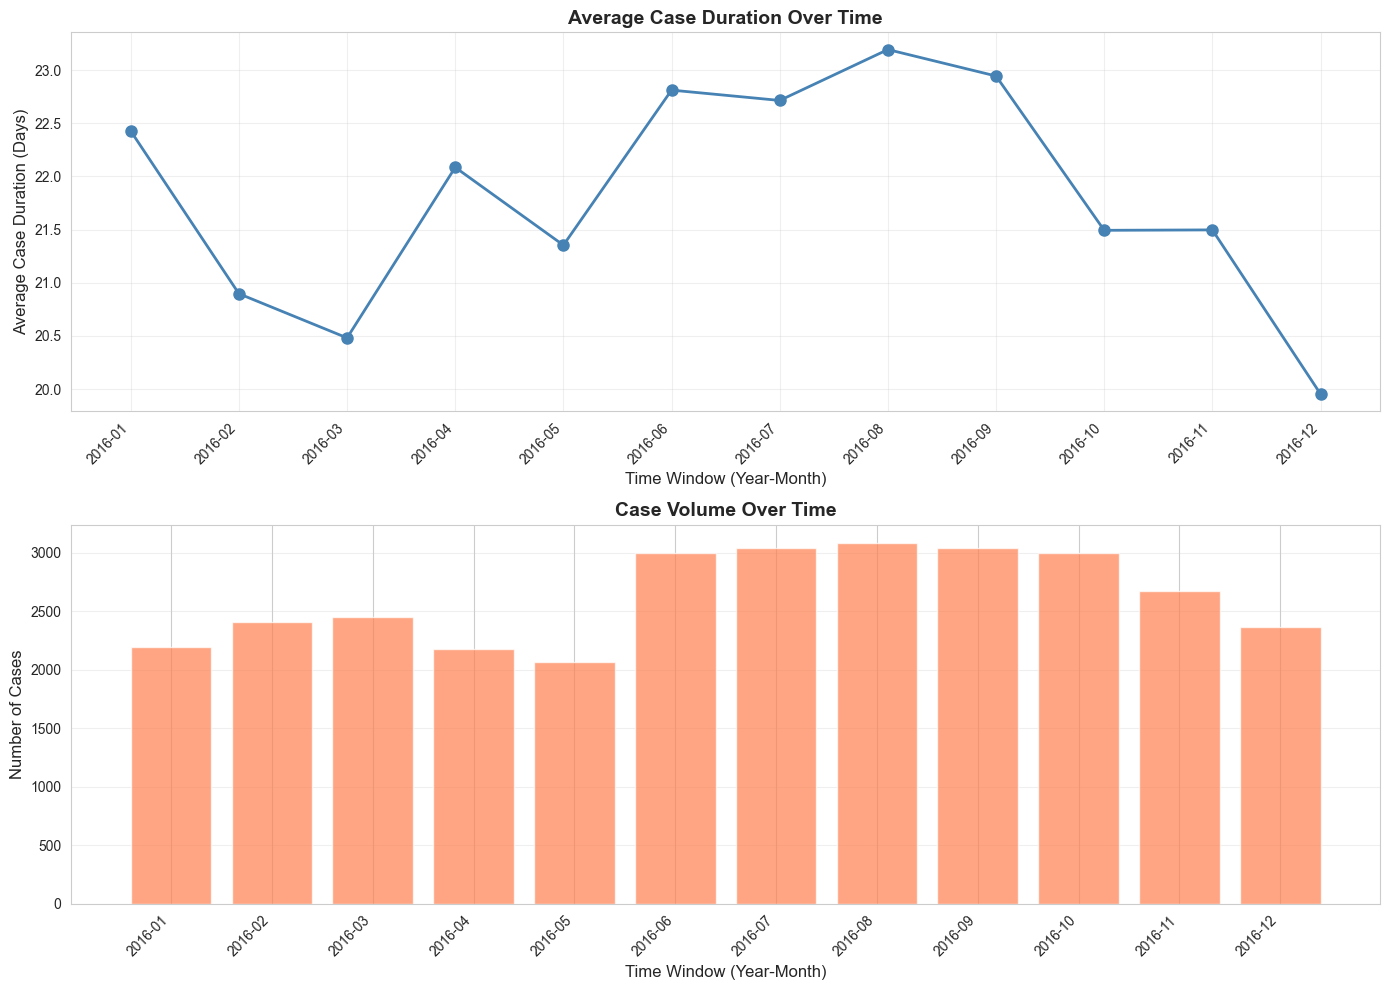

Saved: case_duration_trends.png


In [ ]:
# Case duration trends over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Average case duration
ax1.plot(metrics_df['time_window'], metrics_df['avg_case_duration'], marker='o', linewidth=2, markersize=8, color='steelblue')
ax1.set_xlabel('Time Window (Year-Month)', fontsize=12)
ax1.set_ylabel('Average Case Duration (Days)', fontsize=12)
ax1.set_title('Average Case Duration Over Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Number of cases
ax2.bar(metrics_df['time_window'], metrics_df['num_cases'], color='coral', alpha=0.7)
ax2.set_xlabel('Time Window (Year-Month)', fontsize=12)
ax2.set_ylabel('Number of Cases', fontsize=12)
ax2.set_title('Case Volume Over Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(output_dir / 'case_duration_trends.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: case_duration_trends.png")


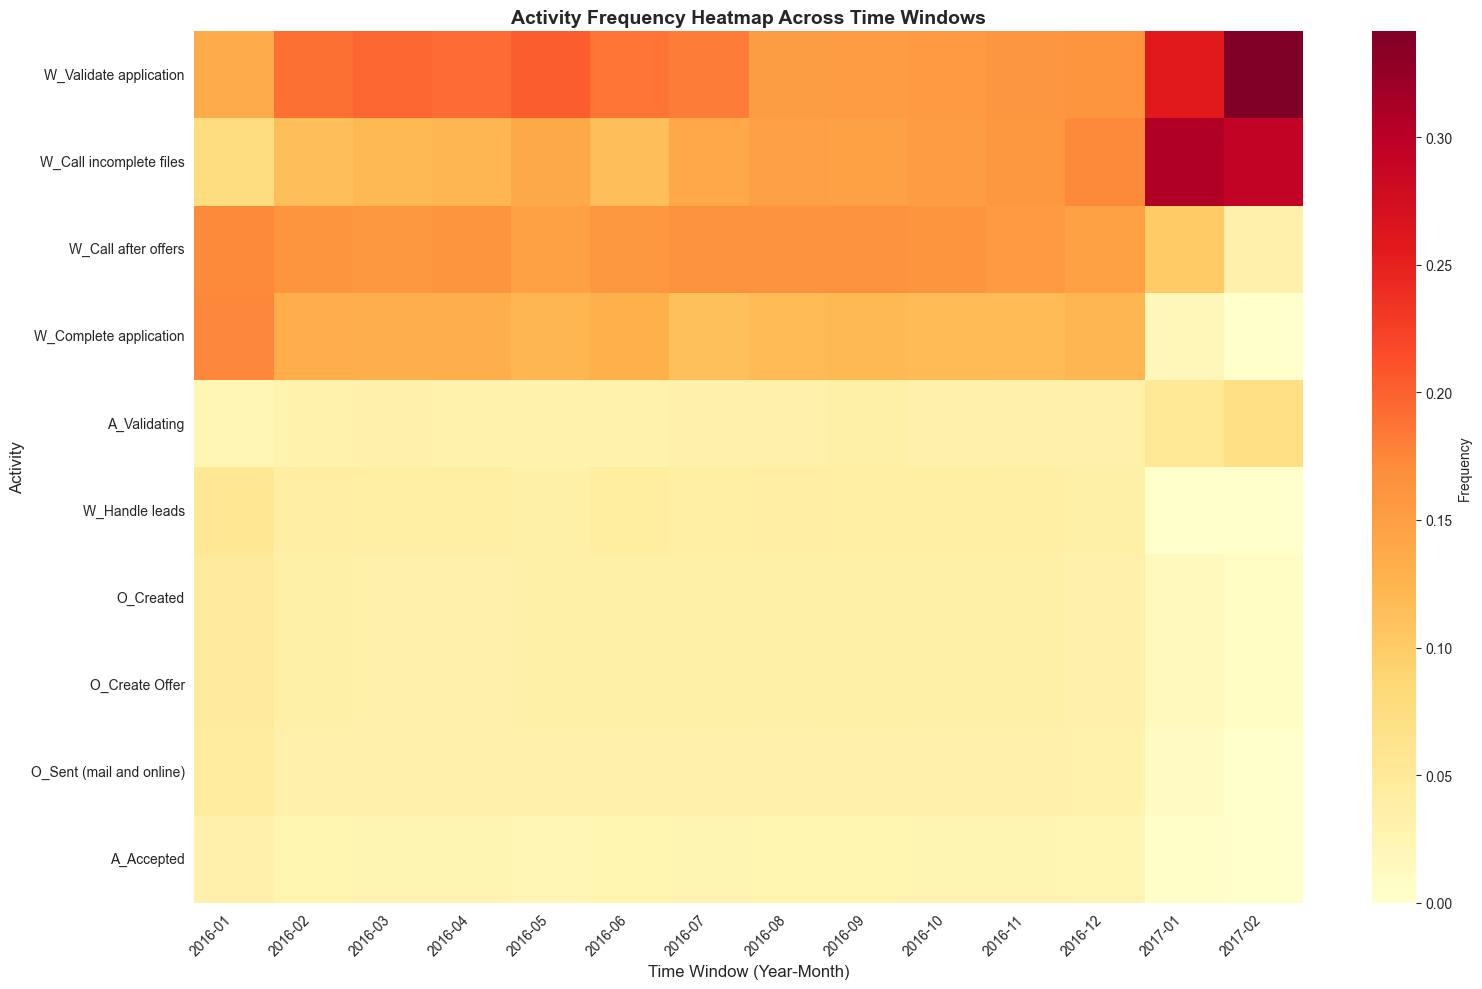

Saved: activity_frequency_heatmap.png


In [ ]:
# Activity distribution heatmap across time windows
activity_pivot = activity_freq_top.pivot(index='concept:name', columns='year_month_str', values='frequency')
activity_pivot = activity_pivot.fillna(0)

# Sort by total frequency
activity_pivot['total'] = activity_pivot.sum(axis=1)
activity_pivot = activity_pivot.sort_values('total', ascending=False).drop('total', axis=1)

fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(activity_pivot, annot=False, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Frequency'}, ax=ax)
ax.set_xlabel('Time Window (Year-Month)', fontsize=12)
ax.set_ylabel('Activity', fontsize=12)
ax.set_title('Activity Frequency Heatmap Across Time Windows', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(output_dir / 'activity_frequency_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: activity_frequency_heatmap.png")


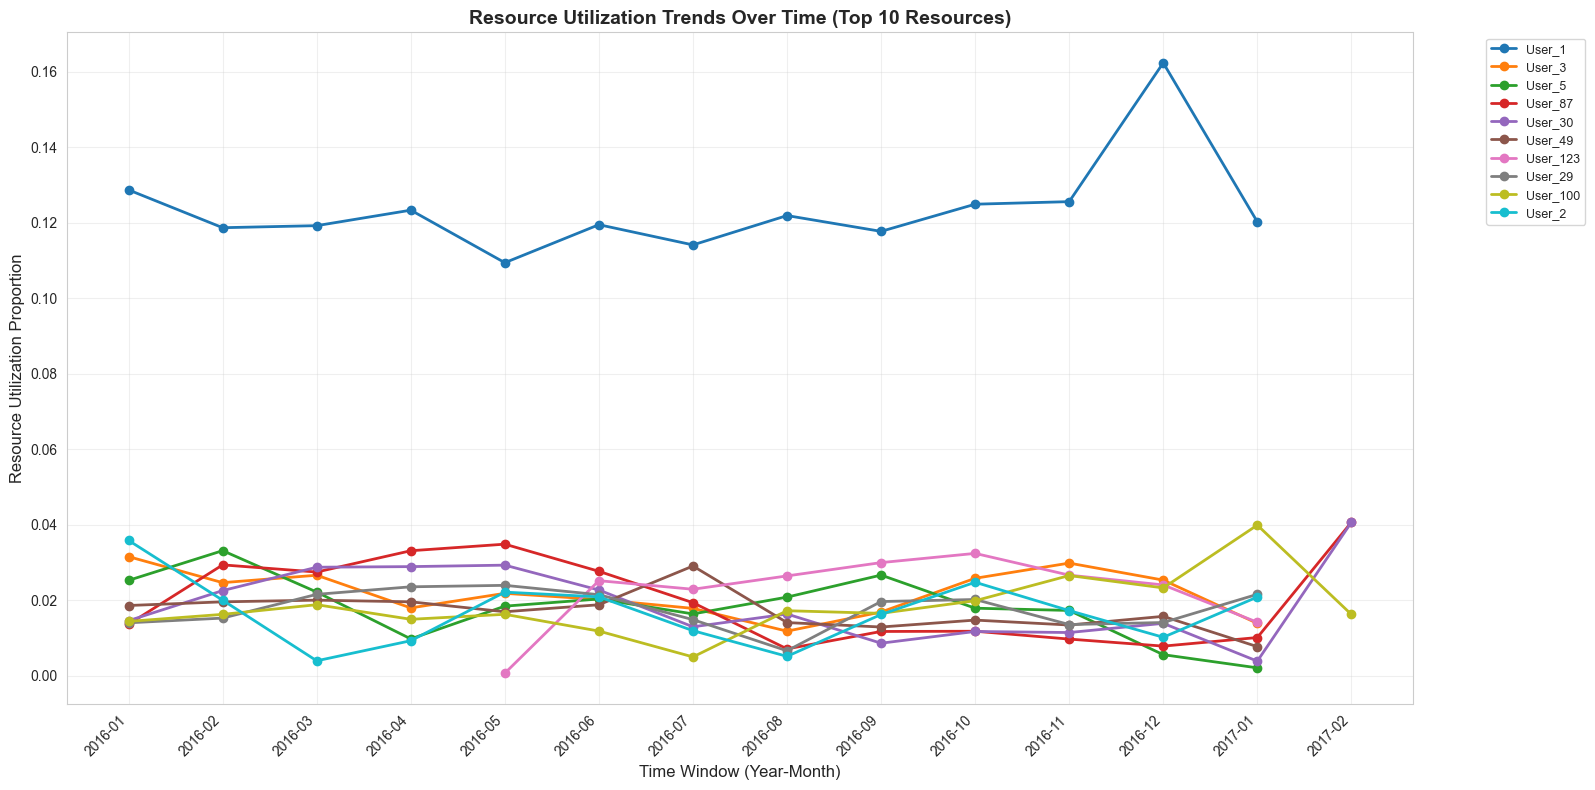

Saved: resource_utilization_trends.png


In [ ]:
# Resource utilization over time
resource_counts = df.groupby(['year_month_str', 'org:resource']).size().reset_index(name='count')
resource_counts = resource_counts.merge(
    df.groupby('year_month_str').size().reset_index(name='total_events'),
    on='year_month_str'
)
resource_counts['resource_proportion'] = resource_counts['count'] / resource_counts['total_events']

# Get top resources
top_resources_all = df['org:resource'].value_counts().head(10).index.tolist()
resource_top = resource_counts[resource_counts['org:resource'].isin(top_resources_all)]

# Plot resource utilization
fig, ax = plt.subplots(figsize=(16, 8))
for resource in top_resources_all:
    resource_data = resource_top[resource_top['org:resource'] == resource]
    ax.plot(resource_data['year_month_str'], resource_data['resource_proportion'], marker='o', label=resource, linewidth=2)

ax.set_xlabel('Time Window (Year-Month)', fontsize=12)
ax.set_ylabel('Resource Utilization Proportion', fontsize=12)
ax.set_title('Resource Utilization Trends Over Time (Top 10 Resources)', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(output_dir / 'resource_utilization_trends.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: resource_utilization_trends.png")


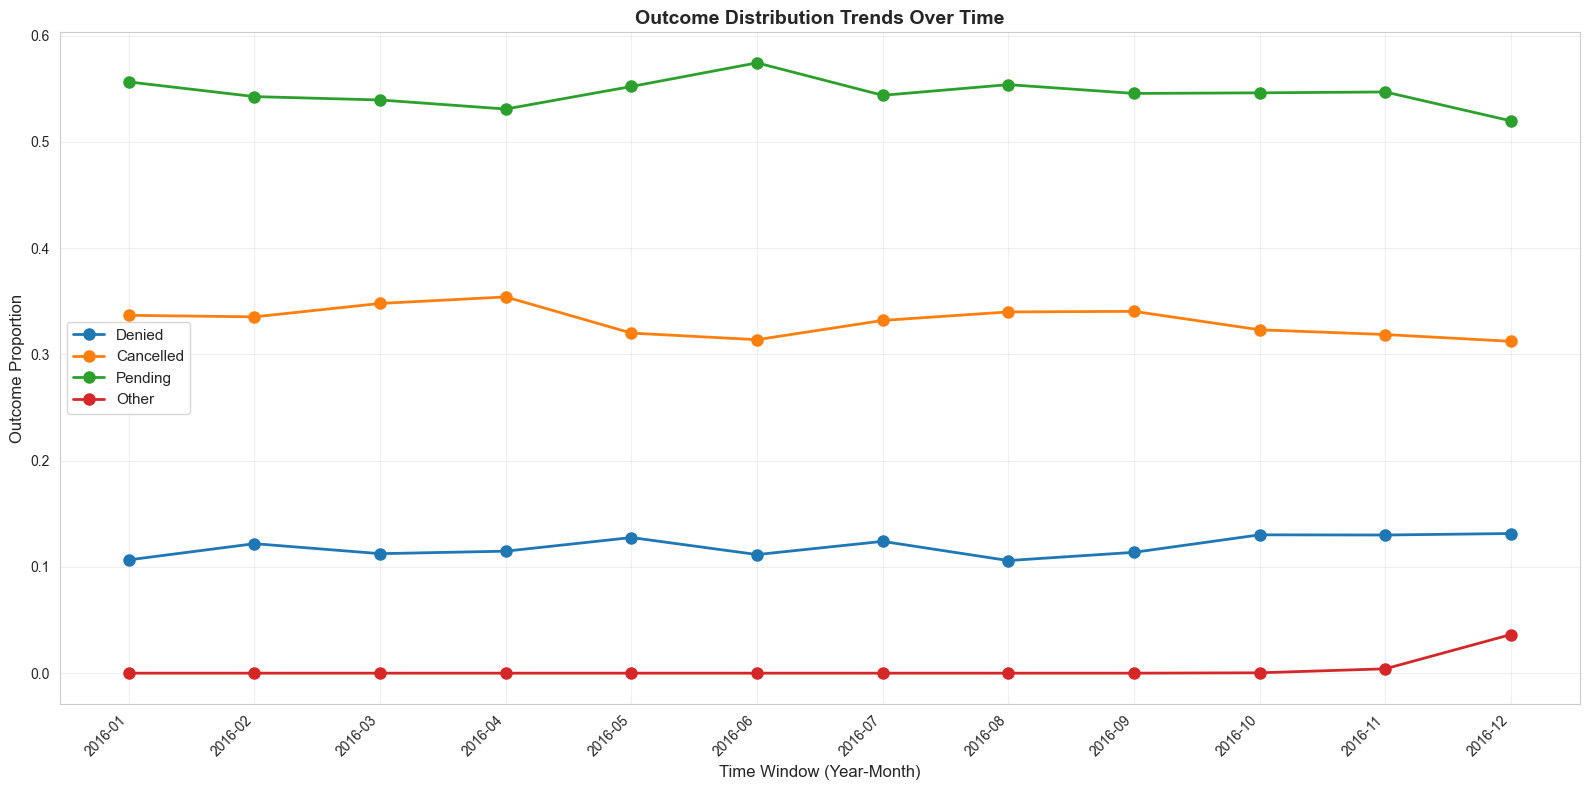

Saved: outcome_distribution_timeseries.png


In [ ]:
# Outcome distribution over time - Time series plot
outcome_cols = ['outcome_Denied_proportion', 'outcome_Cancelled_proportion', 
                'outcome_Pending_proportion', 'outcome_Other_proportion']
outcome_labels = ['Denied', 'Cancelled', 'Pending', 'Other']

fig, ax = plt.subplots(figsize=(16, 8))
for col, label in zip(outcome_cols, outcome_labels):
    ax.plot(metrics_df['time_window'], metrics_df[col], marker='o', label=label, linewidth=2, markersize=8)

ax.set_xlabel('Time Window (Year-Month)', fontsize=12)
ax.set_ylabel('Outcome Proportion', fontsize=12)
ax.set_title('Outcome Distribution Trends Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(output_dir / 'outcome_distribution_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: outcome_distribution_timeseries.png")


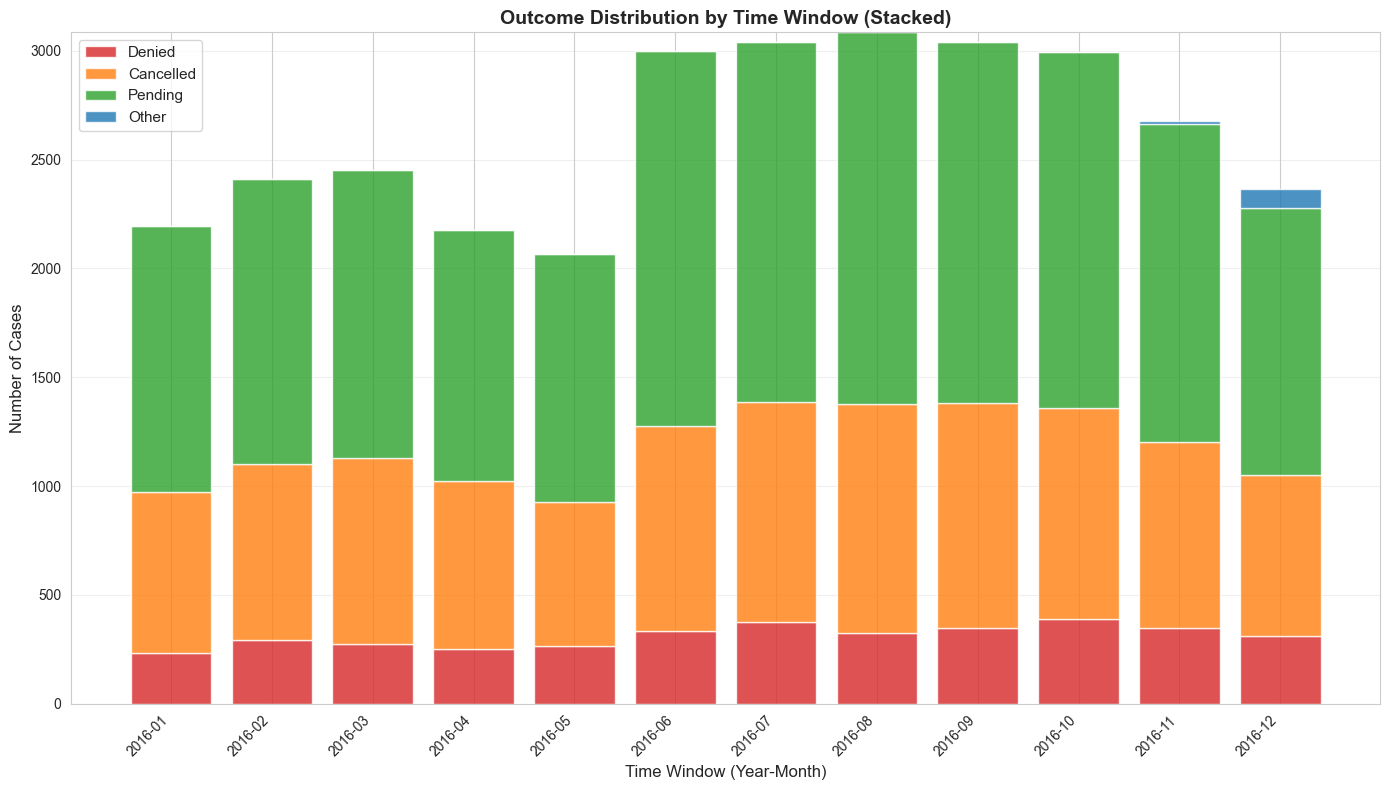

Saved: outcome_distribution_stacked.png


In [ ]:
# Outcome distribution - Stacked bar chart
outcome_count_cols = ['outcome_Denied_count', 'outcome_Cancelled_count', 
                      'outcome_Pending_count', 'outcome_Other_count']

fig, ax = plt.subplots(figsize=(14, 8))
x_pos = np.arange(len(metrics_df))
bottom = np.zeros(len(metrics_df))
colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']

for i, (col, label, color) in enumerate(zip(outcome_count_cols, outcome_labels, colors)):
    ax.bar(x_pos, metrics_df[col], bottom=bottom, label=label, color=color, alpha=0.8)
    bottom += metrics_df[col]

ax.set_xlabel('Time Window (Year-Month)', fontsize=12)
ax.set_ylabel('Number of Cases', fontsize=12)
ax.set_title('Outcome Distribution by Time Window (Stacked)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics_df['time_window'], rotation=45, ha='right')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(output_dir / 'outcome_distribution_stacked.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: outcome_distribution_stacked.png")


In [ ]:
# Summary statistics
print("\n=== Summary Statistics ===")
print(f"Total time windows analyzed: {len(time_windows)}")
print(f"Time period: {time_windows[0]} to {time_windows[-1]}")
print(f"\nAverage case duration range: {metrics_df['avg_case_duration'].min():.2f} to {metrics_df['avg_case_duration'].max():.2f} days")
print(f"Average number of cases per window: {metrics_df['num_cases'].mean():.0f}")
print(f"Average number of unique activities per window: {metrics_df['unique_activities'].mean():.0f}")
print(f"Average number of unique resources per window: {metrics_df['unique_resources'].mean():.0f}")

# Outcome distribution statistics
print("\n=== Outcome Distribution Statistics ===")
print(f"Average Denied proportion: {metrics_df['outcome_Denied_proportion'].mean():.4f} (range: {metrics_df['outcome_Denied_proportion'].min():.4f} - {metrics_df['outcome_Denied_proportion'].max():.4f})")
print(f"Average Cancelled proportion: {metrics_df['outcome_Cancelled_proportion'].mean():.4f} (range: {metrics_df['outcome_Cancelled_proportion'].min():.4f} - {metrics_df['outcome_Cancelled_proportion'].max():.4f})")
print(f"Average Pending proportion: {metrics_df['outcome_Pending_proportion'].mean():.4f} (range: {metrics_df['outcome_Pending_proportion'].min():.4f} - {metrics_df['outcome_Pending_proportion'].max():.4f})")
print(f"Average Other proportion: {metrics_df['outcome_Other_proportion'].mean():.4f} (range: {metrics_df['outcome_Other_proportion'].min():.4f} - {metrics_df['outcome_Other_proportion'].max():.4f})")

# Overall outcome distribution
print("\n=== Overall Outcome Distribution ===")
overall_outcomes = case_data['outcome'].value_counts()
print(overall_outcomes)
print(f"\nOverall proportions:")
for outcome, count in overall_outcomes.items():
    print(f"  {outcome}: {count/len(case_data):.4f}")

# Save metrics
metrics_df.to_csv(output_dir / 'metrics_per_window.csv', index=False)
print(f"\nAll results saved to: {output_dir}")



=== Summary Statistics ===
Total time windows analyzed: 12
Time period: 2016-01 to 2016-12

Average case duration range: 19.95 to 23.19 days
Average number of cases per window: 2626
Average number of unique activities per window: 25
Average number of unique resources per window: 90

=== Outcome Distribution Statistics ===
Average Denied proportion: 0.1192 (range: 0.1060 - 0.1314)
Average Cancelled proportion: 0.3313 (range: 0.3123 - 0.3542)
Average Pending proportion: 0.5461 (range: 0.5199 - 0.5745)
Average Other proportion: 0.0034 (range: 0.0000 - 0.0363)

=== Overall Outcome Distribution ===
outcome
Pending      17228
Cancelled    10431
Denied        3752
Other           98
Name: count, dtype: int64

Overall proportions:
  Pending: 0.5468
  Cancelled: 0.3310
  Denied: 0.1191
  Other: 0.0031

All results saved to: ..\..\Results\Advanced_Analysis\concept_drift
